Saving to: results/monomer-single_D15.0nm_isolated_Exkz


/home/pablo/plytrons/plytrons/bcm_sphere.py:252: RuntimeWarning: invalid value encountered in true_divide
  vector = np.array(vector) / np.array(vector)


<Figure size 640x480 with 0 Axes>

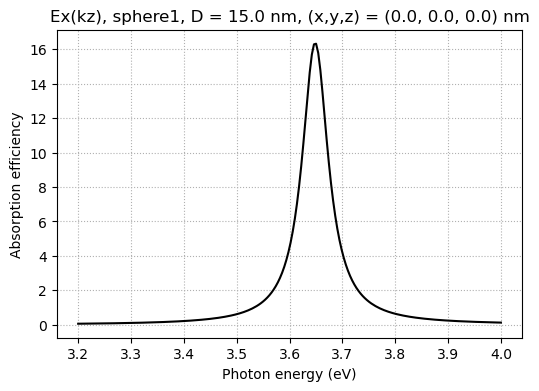

All figures and data saved in: results/monomer-single_D15.0nm_isolated_Exkz


In [12]:
import numpy as np
import plytrons.bcm_sphere as bcm
from plytrons.bcm_sphere import EField, BCMObject
from scipy.constants import hbar, eV, speed_of_light
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from plytrons.plot_utils import make_results_folder

c0 = speed_of_light
Z0, *_ = physical_constants[ "characteristic impedance of vacuum"]
Z0 = Z0 * eV          # Free space impedance (e/V-s)

# Define geometrical parameters
D = 15                      # Diameter of spheres (nm)
lmax = 10                  # Maximum spherical harmonic index

# Define Drude model (silver)
wp = 9.07 * eV / hbar  # rad/s
gw = 0.060 * eV / hbar  # rad/s
eps_b = 4.18

# Define simulation setup
eps_h = 1                                   # Dielectric constant of host
w = np.linspace(3.2, 4.0, 200) * eV / hbar  # frequencies

def eps_drude(x):
    return eps_b - (wp**2) / ((2*np.pi*c0 / x*1E6) * ((2*np.pi*c0 / x * 1E6) + 1j * gw))

efield = EField(
    E0=1,                                 # E-field intensity (V/nm)
    k_hat=bcm.v_normalize([0, 0, 1]),     # Planewave direction
    e_hat=bcm.v_normalize([1, 0, 0])      # E-field vector
)

# Define objects
delta = 1.5  # gap between spheres (nm)
d_c = D + delta  # center-to-center distance (nm)

BCM_objects = [
    BCMObject(
        label='Sphere1',
        diameter=D,
        lmax=lmax,
        eps=eps_drude,
        position=np.array([0, 0, 0])
    )
    # BCMObject(
    #     label='Sphere1',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([-d_c/2, 0, 0])
    # ),
    # BCMObject(
    #     label='Sphere2',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([d_c/2, 0, 0])
    # ),
    # BCMObject(
    #     label='Sphere3',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([0, -np.sqrt(3)/2*d_c, 0])
    # )
]

# Number of spheres
Np = len(BCM_objects)

# Compute interaction matrices and vector
Gi = [None] * Np
G0 = [[None for _ in range(Np)] for _ in range(Np)]
Sv = [None] * Np

for in_idx in range(Np):
    # Compute internal matrix
    Gi[in_idx] = bcm.Ginternal(BCM_objects[in_idx])
    
    # Compute external interaction matrix
    for jn_idx in range(Np):
        G0[in_idx][jn_idx] = bcm.Gexternal(BCM_objects[in_idx], BCM_objects[jn_idx])
    
    # Compute external field coefficients
    Sv[in_idx] = bcm.Efield_coupling(BCM_objects[in_idx], efield)

#-----------------------------------------------------------------------------------------------------
# Solve system
#-----------------------------------------------------------------------------------------------------
Sw = [None] * Np

dx_max = lmax * (lmax + 1) + (lmax + 1) - 1

obj_coef = []
for coef in range(Np):
    obj_coef.append(np.zeros((dx_max, len(w)), dtype=complex))

for il in range(len(w)):
    c, Si = bcm.solve_BCM(w[il], eps_h, BCM_objects, efield, Gi, G0, Sv)
    for in_idx in range(Np):
        obj_coef[in_idx][:, il] = c[in_idx]
        if il == 0:
            Sw[in_idx] = np.zeros((len(Si[in_idx]), len(w)), dtype=complex)
        Sw[in_idx][:, il] = Si[in_idx]

lam_um = 2*np.pi*3E14/w
for idx_obj in range(Np):
    BCM_objects[idx_obj].set_coefficients(lam_um, obj_coef[idx_obj])

# Compute scattering and absorption
Psca, Pabs = bcm.EM_power(w, eps_h, Gi, G0, BCM_objects)

#-----------------------------------------------------------------------------------------------------
# Create Results Folder
#-----------------------------------------------------------------------------------------------------

outdir = make_results_folder(BCM_objects, efield)  # e.g., results/trimer_D5.0nm_gap1.0nm_Exkz
# or with extra info:
# outdir = make_results_folder(BCM_objects, efield, lmax=lmax, eps_h=eps_h, include_timestamp=True)

print("Saving to:", outdir)
plt.savefig(outdir / "absorption_spectrum_sphere1.png", dpi=200)

# Save per-sphere absorption plots
for i, obj in enumerate(BCM_objects, start=1):
    fig, ax = plt.subplots(figsize=(6, 4))
    Ri = obj.diameter / 2.0
    Qabs = Pabs[i-1] / (efield.E0**2 / (2 * Z0)) / (np.pi * Ri**2)

    ax.plot(w * hbar / eV, Qabs, 'k')
    ax.set_title(
        f'E{bcm.get_axis(efield.e_hat)}(k{bcm.get_axis(efield.k_hat)}), '
        f'sphere{i}, D = {obj.diameter:.1f} nm, '
        f'(x,y,z) = ({obj.position[0]:.1f}, {obj.position[1]:.1f}, {obj.position[2]:.1f}) nm'
    )
    ax.set_xlabel('Photon energy (eV)')
    ax.set_ylabel('Absorption efficiency')
    ax.grid(True, ls=':')
    plt.show()
    fig.tight_layout()
    fig.savefig(outdir / f"absorption_spectrum_sphere{i}.png", dpi=200)
    plt.close(fig)


# Quick geometry + run summary
with open(outdir / "geometry.txt", "w") as f:
    f.write(f"N particles: {len(BCM_objects)}\n")
    for i, obj in enumerate(BCM_objects, start=1):
        f.write(
            f"sphere{i}: label={obj.label}, D={obj.diameter:.3f} nm, "
            f"pos=({obj.position[0]:.3f}, {obj.position[1]:.3f}, {obj.position[2]:.3f}) nm, "
            f"lmax={obj.lmax}\n"
        )
    f.write(f"eps_h={eps_h}\n")
    f.write(f"E0={efield.E0} V/nm, e_hat={efield.e_hat}, k_hat={efield.k_hat}\n")

print("All figures and data saved in:", outdir)

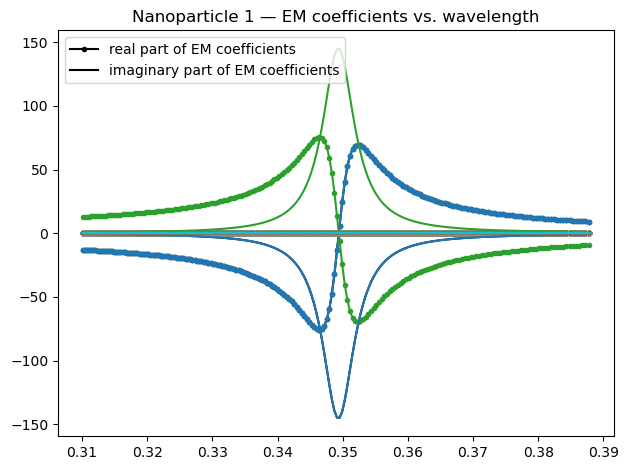

Active l,m -> l=1, m=-1
Active l,m -> l=1, m=1


In [13]:
import numpy as np
from plytrons.plot_utils import print_active_lm, coefficients_plot

for Np in range(len(BCM_objects)):

    lam  = BCM_objects[Np].lam_um
    coef = BCM_objects[Np].BCM_coef

    #--- plot ---
    coefficients_plot(Np ,lam, coef)
    print_active_lm(BCM_objects[Np], thr=10.0)  #prints the active EM l,m coefficients

## Free electron states

We get electronic states from spherical quantum well

In [14]:
import plytrons.quantum_well as qw

a =  D/2
E_matrix = qw.get_bound_states(a)
A_matrix = qw.get_normalization(a, E_matrix)
e_states = qw.e_state_assembly(E_matrix, A_matrix)

## Predicting hot carriers dynamics for each nanoparticle and resonance peak

In [15]:
import numpy as np
from plytrons.hot_carriers import hot_e_dist
import warnings
from numba.core.errors import NumbaTypeSafetyWarning
warnings.simplefilter("ignore", category=NumbaTypeSafetyWarning)
from scipy.signal import find_peaks
from plytrons.math_utils import eps0

# ----------------------------------- Simulation set up---------------------------------------------------------------------------
tau_e = np.linspace(50,1500,59)                                                     # hot carrier lifetime range (fs) 
resonance_peak = 1
Np = 1
#---------------------------------------------------------------------------------------------------------------------------------

peaks_pos = find_peaks(Pabs[Np-1])[0]                                    #Position of the peaks   
lam_target = lam_um[peaks_pos[resonance_peak-1]]                            # Wavelength at maximum absorption
hv         = 2*np.pi*3E14/lam_target*hbar/eV                                             # photon energy (eV)
EF         = 5.5                                                                         # Fermi level (eV)
Pabs_peak  = Pabs[Np-1][peaks_pos[resonance_peak-1]]/(np.pi*eps0)*1e-15        # Absorption power at peak (eV/ps)
X_lm       = BCM_objects[Np-1].coef_at(lam_target)                             # EM coefficients

print('')
print('############################')
print(f'  Nanoparticle number {Np}')
print('############################')
print('')
print(f'Resonance peak number {resonance_peak}')
print(f'Wavelength at peak absorption: {lam_target*1e3:.2f} nm')
print(f'Photon energy: {hv:.2f} eV')
print(f'Absorption power at peak: {Pabs_peak:.2f} eV/ps')


############################
  Nanoparticle number 1
############################

Resonance peak number 1
Wavelength at peak absorption: 339.89 nm
Photon energy: 3.65 eV
Absorption power at peak: 137581.64 eV/ps


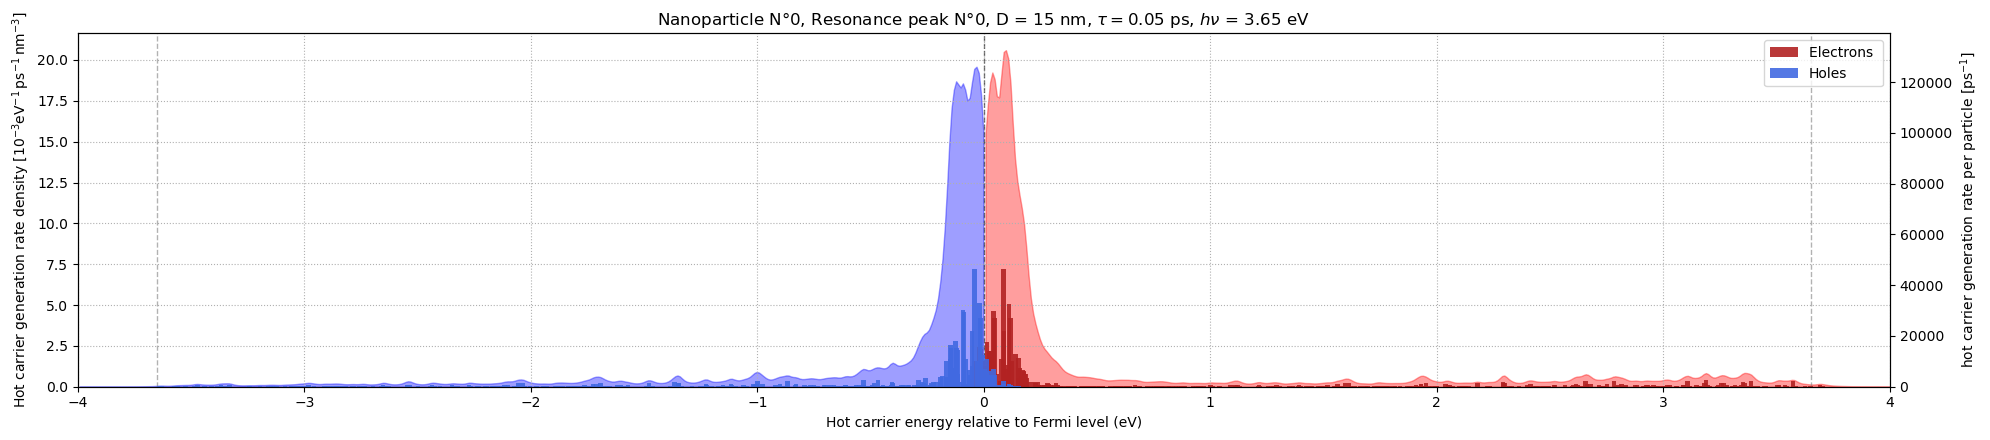

In [21]:
from plytrons.hot_carriers import hot_e_dist
from plytrons.plot_utils import hot_carriers_plot

#------------------------------- Hot Carriers dynamics Simulation ----------------------------------------------------------------

Te_dynamics, Th_dynamics, Te_raw_dynamics, Th_raw_dynamics  = hot_e_dist(a, hv, EF, tau_e, e_states, X_lm, Pabs_peak)

#------------------------------- Plotting ----------------------------------------------------------------------------------------

# -------------------- edit these to set the plot --------------------
tau = 50                  # decay period to plot
dE_factor = 5              # broadening factor (relative to grid step)
delta = 4.0                # plot window around EF (eV)
# --------------------------------------------------------------------

idx = np.abs(tau_e - tau).argmin() #Get the closest value to the decay period selected

hot_carriers_plot(Te_dynamics[idx], Th_dynamics[idx], Te_raw_dynamics[idx], Th_raw_dynamics[idx], 
                  e_states, Np, resonance_peak, tau, D, hv, EF, dE_factor, delta)

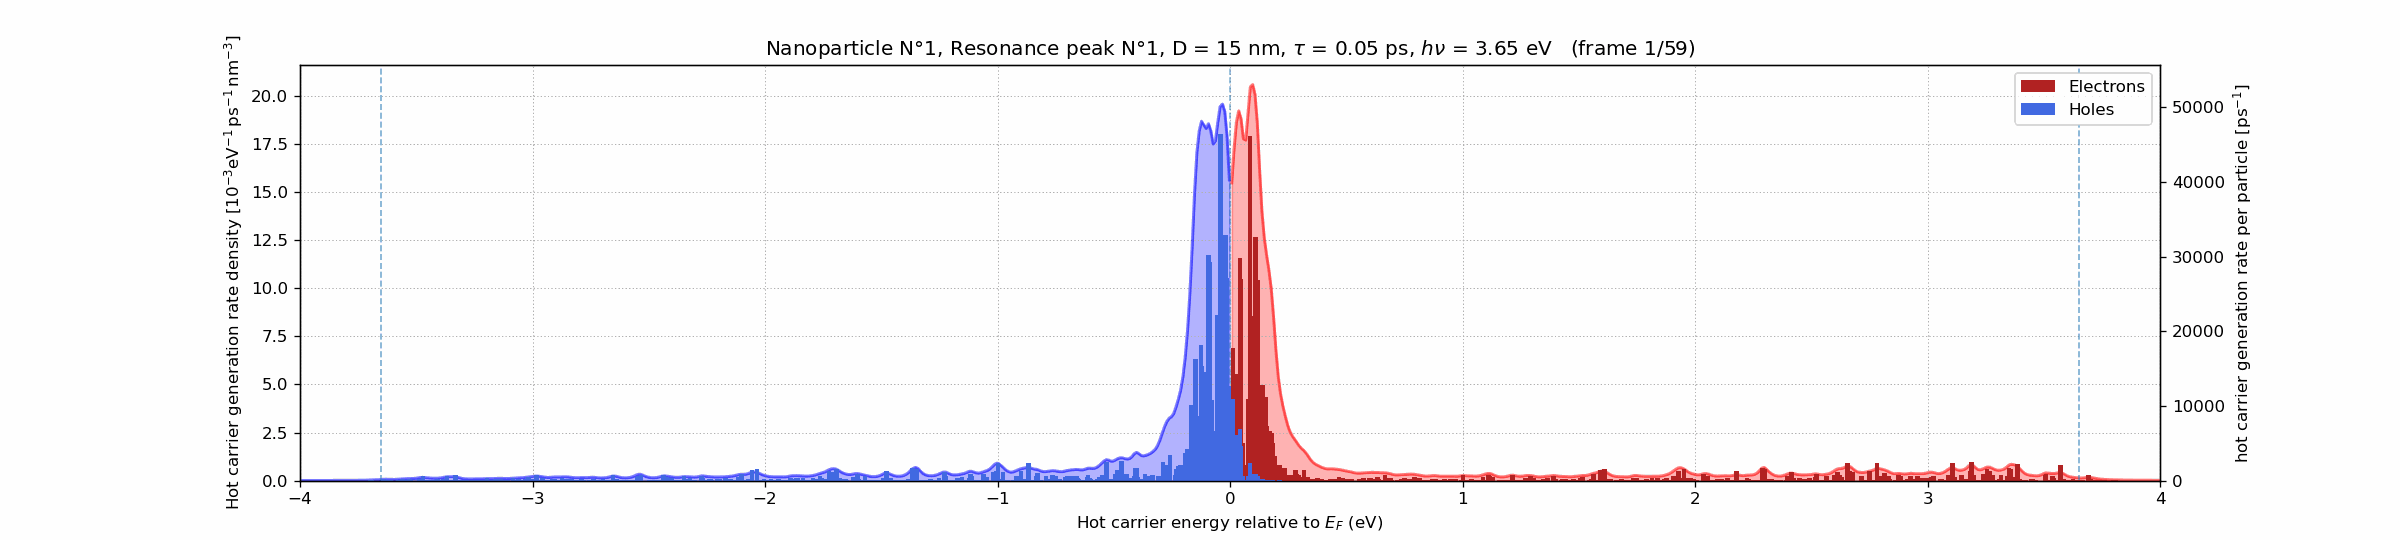

In [17]:
#------------------------------- Animation ---------------------------------------------------------------------------------------

from plytrons.plot_utils import hot_carrier_dynamics_plot

# ===================== editable parameters =====================
EF = 5.5          # eV
dE_factor = 5     # Lorentzian broadening factor (relative to grid step)
delta = 4.0       # eV window around EF for plotting
fps = 6           # frames per second for the GIF
out_path = f"{outdir}/hot_carriers_dynamics_Np{Np}_Res{resonance_peak}.gif"  # save path 
# ===============================================================

hot_carrier_dynamics_plot(Te_dynamics, Th_dynamics, Te_raw_dynamics, Th_raw_dynamics
                          , e_states, Np, resonance_peak, tau_e, D, hv, EF, dE_factor, delta, fps, out_path)

## Predicting hot carrier dynamics for the full system

In [18]:
import numpy as np
from plytrons.hot_carriers import hot_e_dist
import warnings
from numba.core.errors import NumbaTypeSafetyWarning
warnings.simplefilter("ignore", category=NumbaTypeSafetyWarning)
from scipy.signal import find_peaks
from plytrons.math_utils import eps0

# ----------------------------------- Simulation set up---------------------------------------------------------------------
tau_e = np.linspace(50,1500,59)                                              # hot carrier lifetime range (fs)
#---------------------------------------------------------------------------------------------------------------------------

# hot carrier simulation inputs

Te_dynamics, Te_raw_dynamics = [], []
Th_dynamics, Th_raw_dynamics = [], []

for Np in range(len(BCM_objects)):


    peaks_pos = find_peaks(Pabs[Np])[0]                                    #Position of the peaks   

    print('')
    print('############################')
    print(f'  Nanoparticle number {Np+1}')
    print('############################')
    print('')
    for resonance_peak in range(len(peaks_pos)):

        lam_target = lam_um[peaks_pos[resonance_peak]]                            # Wavelength at maximum absorption
        hv         = 2*np.pi*3E14/lam_target*hbar/eV                                             # photon energy (eV)
        EF         = 5.5                                                                         # Fermi level (eV)
        Pabs_peak  = Pabs[Np][peaks_pos[resonance_peak]]/(np.pi*eps0)*1e-15        # Absorption power at peak (eV/ps)
        X_lm       = BCM_objects[Np].coef_at(lam_target)                                          # EM coefficients

        print(f'Resonance peak number {resonance_peak+1}')
        print(f'Wavelength at peak absorption: {lam_target*1e3:.2f} nm')
        print(f'Photon energy: {hv:.2f} eV')
        print(f'Absorption power at peak: {Pabs_peak:.2f} eV/ps')
        print('-------------------------------------------------------')

        #------------------------------- Hot Carriers dynamics Simulation -----------------------------------------------

        from plytrons.hot_carriers import hot_e_dist
        Te, Th, Te_raw, Th_raw  = hot_e_dist(a, hv, EF, tau_e, e_states, X_lm, Pabs_peak)

        Te_dynamics.append(Te)
        Th_dynamics.append(Th)
        Te_raw_dynamics.append(Te_raw)
        Th_raw_dynamics.append(Th_raw)  
        
                      


############################
  Nanoparticle number 1
############################

Resonance peak number 1
Wavelength at peak absorption: 339.89 nm
Photon energy: 3.65 eV
Absorption power at peak: 137581.64 eV/ps
-------------------------------------------------------


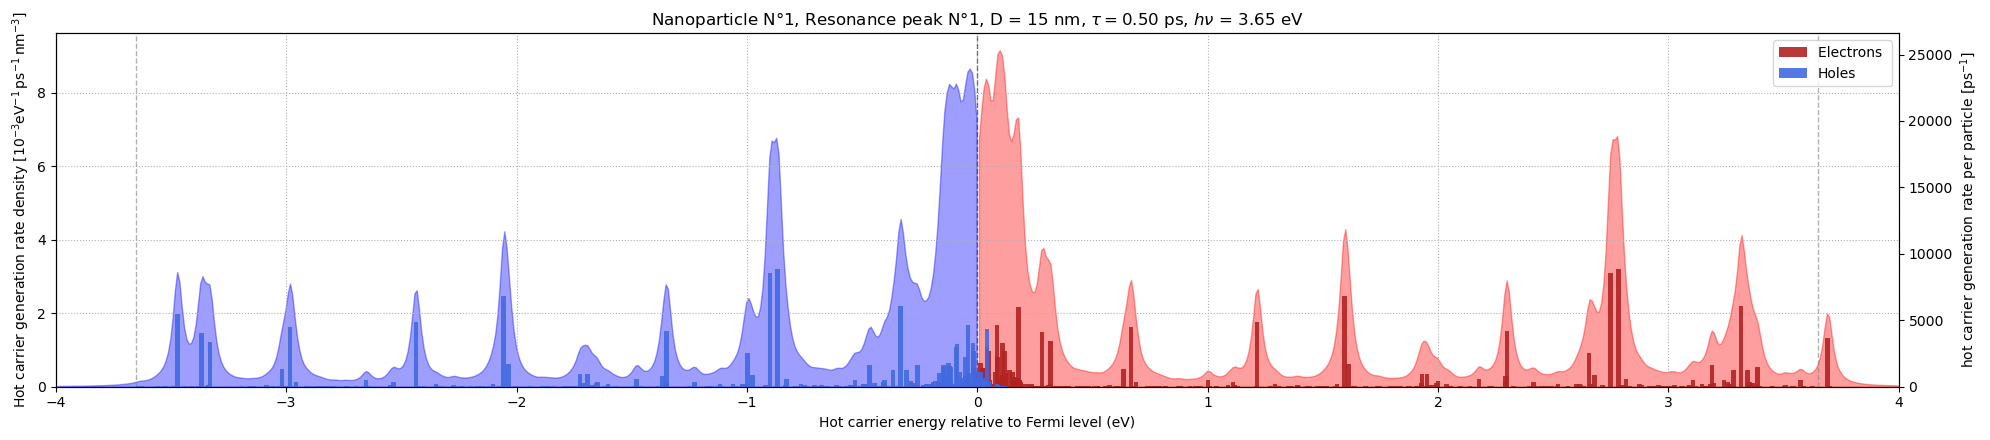

In [19]:
#------------------------------- Plotting ----------------------------------------------------------------------------------------

from plytrons.plot_utils import hot_carriers_plot


# -------------------- edit these to set the plot --------------------
tau = 500                  # decay period to plot
dE_factor = 5              # broadening factor (relative to grid step)
delta = 4.0                # plot window around EF (eV)
# --------------------------------------------------------------------

idx = np.abs(tau_e - tau).argmin() #Get the closest value to the decay period selected

flag = 0
for Np in range(len(BCM_objects)):
    for resonance_peak in range(len(peaks_pos)):
        hot_carriers_plot(Te_dynamics[flag][idx], Th_dynamics[flag][idx], Te_raw_dynamics[flag][idx], Th_raw_dynamics[flag][idx],
                           e_states, Np+1, resonance_peak+1, tau, D, hv, EF, dE_factor, delta)
        
        flag += 1

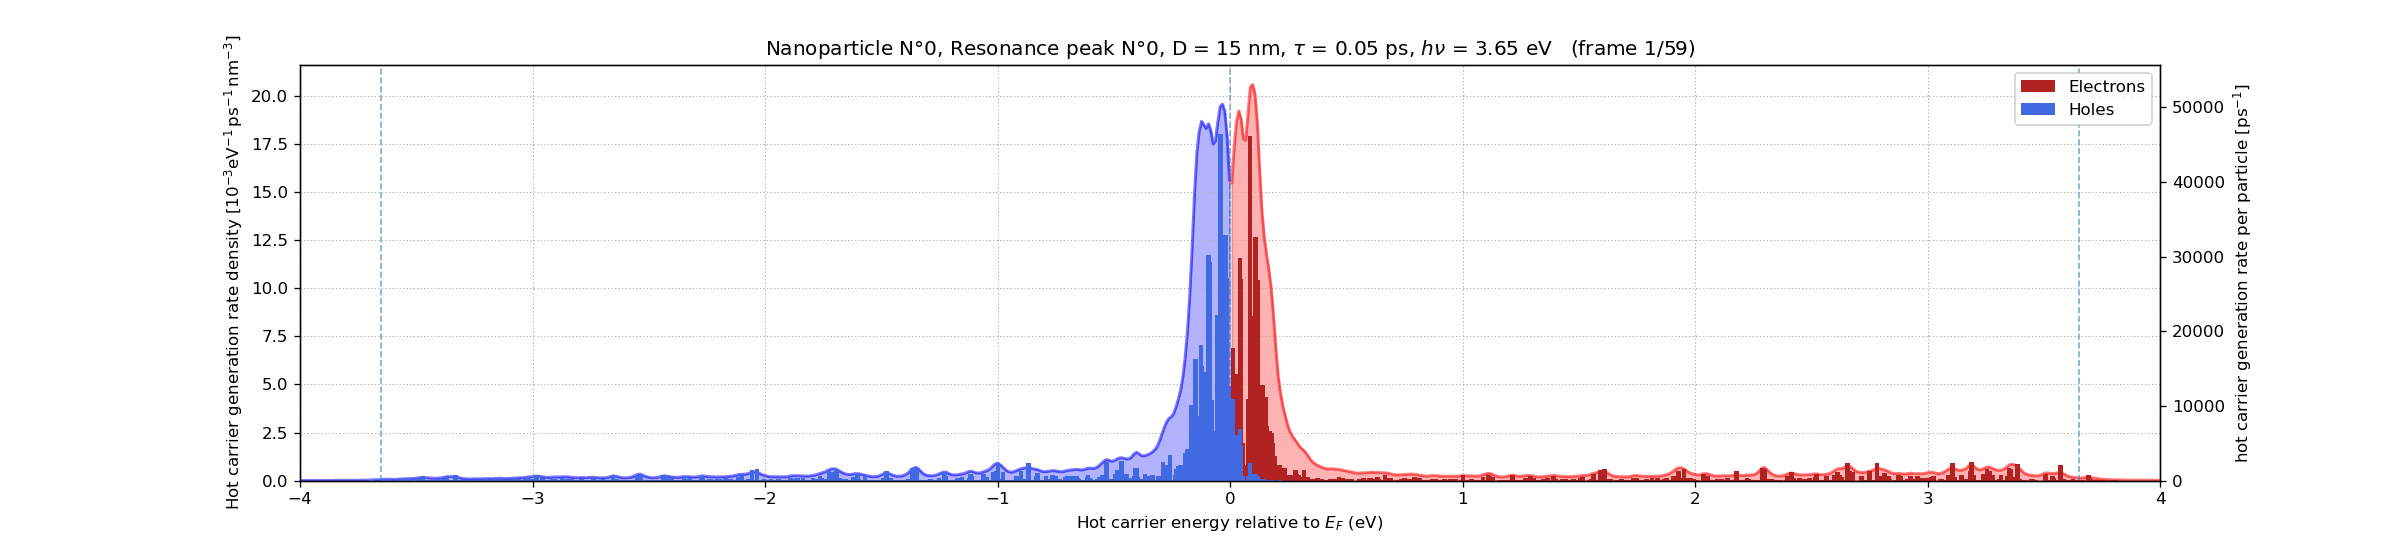

In [20]:
#------------------------------- Animation ---------------------------------------------------------------------------------------

from plytrons.plot_utils import hot_carrier_dynamics_plot

# ===================== editable parameters =====================
EF = 5.5          # eV
dE_factor = 5     # Lorentzian broadening factor (relative to grid step)
delta = 4.0       # eV window around EF for plotting
fps = 6           # frames per second for the GIF
# ===============================================================

flag = 0
for Np in range(len(BCM_objects)):
    for resonance_peak in range(len(peaks_pos)):
        out_path = f"{outdir}/hot_carriers_dynamics_Np{Np+1}_Res{resonance_peak+1}.gif"  # save path 
        hot_carrier_dynamics_plot(Te_dynamics[flag], Th_dynamics[flag], Te_raw_dynamics[flag], Th_raw_dynamics[flag]
                                  , e_states, Np, resonance_peak, tau_e, D, hv, EF, dE_factor, delta, fps, out_path)
        flag += 1